Random Walk is a technique to extract sequences from a graph. We can use these sequences to train a skip-gram model to learn node embeddings.

to obtain node embeddings, we first need to arrange for sequences of nodes from the graph. How do we get these sequences from a graph? Well, there is a technique for this task called Random Walk.

After generating node-sequences, we have to feed them to a skip-gram model to get node embeddings. That entire process is known as DeepWalk.

You can get the dataset from https://densitydesign.github.io/strumentalia-seealsology/

Steps to download:

a) Enter the following links:

https://en.wikipedia.org/wiki/Space_research

https://en.wikipedia.org/wiki/Space_Race

https://en.wikipedia.org/wiki/Space_exploration

b) Download the TSV file.

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

In [2]:
# Both source and target contain Wikipedia entities. 
# For any row, the entity, in target, has its hyperlink in the Wikipedia page of the entity in the source column.
df = pd.read_csv("space_data.tsv", sep = "\t")
df.head()

,source,target,depth
0,space exploration,discovery and exploration of the solar system,1
1,space exploration,in-space propulsion technologies,1
2,space exploration,robotic spacecraft,1
3,space exploration,timeline of planetary exploration,1
4,space exploration,landings on other planets,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3328 entries, 0 to 3327
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   source  3328 non-null   object
 1   target  3328 non-null   object
 2   depth   3328 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 78.1+ KB


In [3]:
G = nx.from_pandas_edgelist(df, "source", "target", edge_attr=True, create_using=nx.Graph())

In [6]:
# number of nodes
len(G)

2088

In [23]:
list(G.neighbors('space exploration'))

['discovery and exploration of the solar system',
 'in-space propulsion technologies',
 'robotic spacecraft',
 'timeline of planetary exploration',
 'landings on other planets',
 'pioneer program',
 'luna program',
 'zond program',
 'venera program',
 'mars probe program',
 'ranger program',
 'mariner program',
 'surveyor program',
 'viking program',
 'voyager program',
 'vega program',
 'phobos program',
 'discovery program',
 'chandrayaan-1',
 'mars orbiter mission',
 'chinese lunar exploration program',
 'astrobotic technology',
 'interplanetary contamination',
 'animals in space',
 'monkeys in space',
 'russian space dogs',
 'astronaut',
 'vostok program',
 'mercury program',
 'voskhod program',
 'gemini program',
 'soyuz program',
 'apollo program',
 'salyut',
 'skylab',
 'space shuttle program',
 'mir',
 'international space station',
 'vision for space exploration',
 'aurora programme',
 'scaled composites tier one',
 'effect of spaceflight on the human body',
 'space architectu

In [24]:
def get_randomwalk(node, path_length):
    
    random_walk = [node]
    
    for i in range(path_length-1):
        temp = list(G.neighbors(node))
        temp = list(set(temp) - set(random_walk))  # make sure the same node won't be chosen again
        if len(temp) == 0:  # it may stop before 10 steps
            break

        random_node = random.choice(temp)  # random choose one neighbor node
        random_walk.append(random_node)
        node = random_node  # assign the random node as the current node
        
    return random_walk

In [27]:
# every time the result might be different
get_randomwalk('space exploration', 10)

['space exploration', 'shuttle buran program', 'n1 (rocket)']

In [30]:
list(G.nodes())[1:10]

['discovery and exploration of the solar system',
 'in-space propulsion technologies',
 'robotic spacecraft',
 'timeline of planetary exploration',
 'landings on other planets',
 'pioneer program',
 'luna program',
 'zond program',
 'venera program']

In [39]:
# get list of all nodes from the graph
all_nodes = list(G.nodes())

random_walks = []
for n in tqdm(all_nodes):
    for i in range(5):  # get five random walk results for one starting node
        random_walks.append(get_randomwalk(n, 10))

100%|██████████| 2088/2088 [00:00<00:00, 6768.01it/s]


In [40]:
# count of sequences
len(random_walks)

10440

In [41]:
random_walks[1:10]

[['space exploration',
  'in-space propulsion technologies',
  'plasma propulsion engine',
  'ion thruster',
  'nuclear pulse propulsion',
  'stellarator'],
 ['space exploration',
  'commercial astronaut',
  'rocketship tours',
  'private spaceflight',
  'garvey spacecraft',
  'space launch market competition',
  'billionaire space race',
  'commercialization of space',
  'space tourism',
  'reduced-gravity aircraft'],
 ['space exploration',
  'sample return mission',
  'discovery and exploration of the solar system',
  'timeline of space exploration',
  'timeline of artificial satellites and space probes',
  'space telescope',
  'earth observation satellite',
  'satellite imagery',
  'remote sensing',
  'mobile mapping'],
 ['space exploration',
  'spacecraft',
  'timeline of solar system exploration',
  'timeline of discovery of solar system planets and their moons',
  'timeline of planetary exploration',
  'new frontiers program',
  'cosmic vision'],
 ['discovery and exploration of t

In [42]:
from gensim.models import Word2Vec

import warnings
warnings.filterwarnings('ignore')

In [43]:
# train skip-gram (word2vec) model
model = Word2Vec(window = 4, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(random_walks, progress_per=2)

model.train(random_walks, total_examples = model.corpus_count, epochs=20, report_delay=1)

(979131, 1008420)

In [44]:
model.similar_by_word('space tourism')

[('space flight participant', 0.8065043687820435),
 ('reduced-gravity aircraft', 0.7688517570495605),
 ('astronaut training', 0.7665769457817078),
 ('micro-g environment', 0.7343843579292297),
 ('beal aerospace', 0.7225710153579712),
 ('space adventures', 0.6986613273620605),
 ('space tourism society', 0.6976269483566284),
 ('nuclear powers', 0.6631918549537659),
 ('microgravity university', 0.6600197553634644),
 ('starchaser industries', 0.657505989074707)]

In [45]:
terms = ['lunar escape systems','soviet moonshot', 'soyuz 7k-l1', 
         'moon landing','space food', 'food systems on space exploration missions', 
         'meal, ready-to-eat','space law', 'metalaw', 'moon treaty', 
         'legal aspects of computing','astronaut training', 'reduced-gravity aircraft', 
         'space adaptation syndrome', 'micro-g environment']

In [46]:
def plot_nodes(word_list):
    X = model[word_list]
    
    # reduce dimensions to 2
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)
    
    
    plt.figure(figsize=(12,9))
    # create a scatter plot of the projection
    plt.scatter(result[:, 0], result[:, 1])
    for i, word in enumerate(word_list):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))
        
    plt.show()

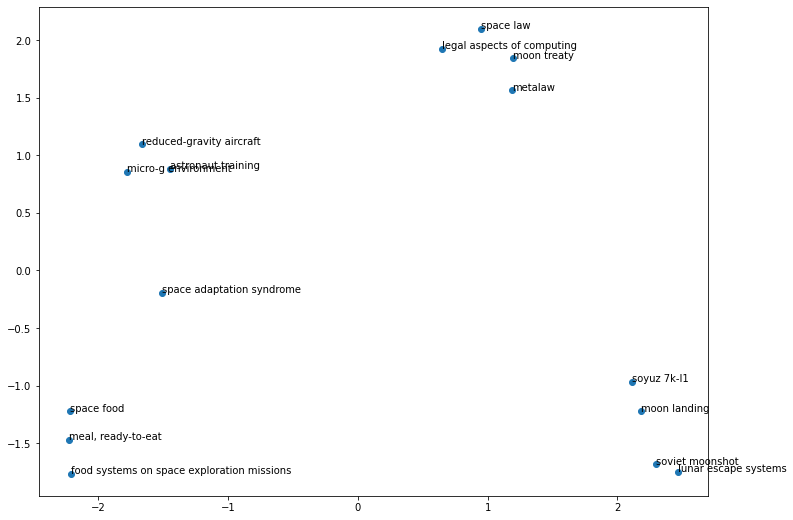

In [47]:
plot_nodes(terms)